<mark>**Seen Population for PT**</mark>  : We used the ABCS file for part-time students from sitelink : https://www.officeforstudents.org.uk/data-and-analysis/associations-between-characteristics-of-students/progressing-from-part-time-higher-education/   to map the characteristics of each student. We obtained the predicted outcome rate and quintiles attached to each student, then quantified how close the predictions were to the actual historical progression outcome flag. This process involves setting a threshold for the predicted outcome rate to classify students as positive or negative, as historical progression is binary (positive/negative)

<mark>**Importing Libraries**</mark>

In [1]:
from datetime import datetime 
from dateutil.relativedelta import relativedelta
import pandas as pd
from pyspark.sql.functions import from_json, col
from pyspark.sql.types import MapType, StringType
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 3, Finished, Available, Finished)

<mark>**pt ofs data**</mark>

In [2]:
df_p = spark.sql("SELECT * FROM SilverData.external_progression_data")
df_pt=df_p.toPandas()
df_pt

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 4, Finished, Available, Finished)

,Adult_HE_quintile,Age_group,Disability,Ethnicity,IDACI,IMD,Local_or_distance_learner,Sex,Predicted_outcome_rate,Derived_progression_quintile,createdAt
0,-- Any quintile --,21-25,Cognitive or learning difficulties,Asian or Asian British - Pakistani,-- Any quintile --,-- Any quintile --,Local,Female,0.620000,1,2024-11-25 08:59:18.184056
1,-- Any quintile --,21-25,Cognitive or learning difficulties,Black or black British - African,-- Any quintile --,-- Any quintile --,Local,Female,0.730000,1,2024-11-25 08:59:18.184056
2,-- Any quintile --,21-25,Cognitive or learning difficulties,Black or black British - Caribbean,-- Any quintile --,-- Any quintile --,Local,Female,0.670000,1,2024-11-25 08:59:18.184056
3,-- Any quintile --,21-25,Cognitive or learning difficulties,Mixed - other,-- Any quintile --,-- Any quintile --,Local,Female,0.740000,1,2024-11-25 08:59:18.184056
4,-- Any quintile --,21-25,Cognitive or learning difficulties,Mixed - other,-- Any quintile --,-- Any quintile --,Local,Female,0.740000,1,2024-11-25 08:59:18.184056
...,...,...,...,...,...,...,...,...,...,...,...
770852,-- Any quintile --,-- Any age group --,No disability reported,Asian or Asian British - Indian,-- Any quintile --,-- Any quintile --,Neither,Male,0.820000,3,2024-11-25 08:59:18.184056
770853,-- Any quintile --,-- Any age group --,No disability reported,Asian or Asian British - Indian,-- Any quintile --,-- Any quintile --,Neither,Male,0.820000,3,2024-11-25 08:59:18.184056
770854,-- Any quintile --,-- Any age group --,No disability reported,Asian or Asian British - Indian,-- Any quintile --,-- Any quintile --,Neither,Male,0.820000,3,2024-11-25 08:59:18.184056
770855,-- Any quintile --,-- Any age group --,No disability reported,Asian or Asian British - Indian,-- Any quintile --,-- Any quintile --,Neither,Male,0.820000,3,2024-11-25 08:59:18.184056


<mark>**Mapping Any categories as blanks and Distance as PT**</mark>

In [3]:
df_pt1 = df_pt.replace({
    '-- Any quintile --':'', 
    '-- Any disability --':'', 
    '-- Any ethnicity --':'', 
    '-- Any quintile --':'', 
    '-- Any learner --': '',
    '-- Any sex --': '',
    'Distance':'PT',
    '-- Any age group --':''  
})

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 5, Finished, Available, Finished)

<mark>**Filtering PT combinations only**</mark>

In [4]:
df_pt1= df_pt1[df_pt1['Local_or_distance_learner']=='PT']
df_pt1

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 6, Finished, Available, Finished)

,Adult_HE_quintile,Age_group,Disability,Ethnicity,IDACI,IMD,Local_or_distance_learner,Sex,Predicted_outcome_rate,Derived_progression_quintile,createdAt
1003,,21-25,Cognitive or learning difficulties,Mixed - white and black African,,,PT,Female,0.750000,1,2024-11-25 08:59:18.184056
1004,Quintile 1,21-25,Cognitive or learning difficulties,,,,PT,Female,0.720000,1,2024-11-25 08:59:18.184056
1005,,21-25,Cognitive or learning difficulties,,Quintile 1,,PT,Female,0.740000,1,2024-11-25 08:59:18.184056
1006,,21-25,Cognitive or learning difficulties,,Quintile 1,,PT,Female,0.740000,1,2024-11-25 08:59:18.184056
1007,,21-25,Cognitive or learning difficulties,,,Quintile 1,PT,Female,0.730000,1,2024-11-25 08:59:18.184056
...,...,...,...,...,...,...,...,...,...,...,...
770847,,,No disability reported,Asian or Asian British - Indian,,,PT,Male,0.820000,3,2024-11-25 08:59:18.184056
770848,,,No disability reported,Asian or Asian British - Indian,,,PT,Male,0.820000,3,2024-11-25 08:59:18.184056
770849,,,No disability reported,Asian or Asian British - Indian,,,PT,Male,0.820000,3,2024-11-25 08:59:18.184056
770850,,,No disability reported,Asian or Asian British - Indian,,,PT,Male,0.820000,3,2024-11-25 08:59:18.184056


In [5]:
df_pt1.nunique()

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 7, Finished, Available, Finished)

Adult_HE_quintile                6
Age_group                        9
Disability                       7
Ethnicity                       15
IDACI                            6
IMD                              6
Local_or_distance_learner        1
Sex                              3
Predicted_outcome_rate          78
Derived_progression_quintile     5
createdAt                        1
dtype: int64

<mark>**Checking all the unique categories**</mark>

In [6]:
df_pt1['Disability'].unique()

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 8, Finished, Available, Finished)

array(['Cognitive or learning difficulties',
       'Sensory, medical or physical impairments',
       'Multiple or other impairments',
       'Social or communication impairment', 'Mental health condition',
       '', 'No disability reported'], dtype=object)

In [7]:
df_pt1['Adult_HE_quintile'].unique()

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 9, Finished, Available, Finished)

array(['', 'Quintile 1', 'Quintile 2', 'Quintile 3', 'Quintile 4',
       'Quintile 5'], dtype=object)

In [8]:
df_pt1['IDACI'].unique()

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 10, Finished, Available, Finished)

array(['', 'Quintile 1', 'Quintile 2', 'Quintile 3', 'Quintile 4',
       'Quintile 5'], dtype=object)

In [9]:
df_pt1['Age_group'].unique()

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 11, Finished, Available, Finished)

array(['21-25', '31-40', '26-30', '41-50', '51+', '', '19', '20',
       '18 and under'], dtype=object)

In [10]:
df_pt1['IMD'].unique()

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 12, Finished, Available, Finished)

array(['', 'Quintile 1', 'Quintile 2', 'Quintile 3', 'Quintile 4',
       'Quintile 5'], dtype=object)

In [11]:
df_pt1['Ethnicity'].unique()

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 13, Finished, Available, Finished)

array(['Mixed - white and black African', '', 'White',
       'Other ethnic group', 'Asian or Asian British - Indian',
       'Asian or Asian British - Pakistani',
       'Asian or Asian British - other',
       'Black or black British - African',
       'Black or black British - Caribbean',
       'Black or black British - other', 'Mixed - other',
       'Asian or Asian British - Bangladeshi',
       'Mixed - white and black Caribbean', 'Refused or unknown',
       'Mixed - white and Asian'], dtype=object)

In [12]:
df_pt1['Sex'].unique()

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 14, Finished, Available, Finished)

array(['Female', '', 'Male'], dtype=object)

<mark>**Creating Concatenated column by adding all the characteristic**</mark>

In [13]:
# Concatenate columns by converting all values to strings
df_pt1['Concatenated_column'] = (
    df_pt1['Adult_HE_quintile'].astype(str) + 
    df_pt1['Age_group'].astype(str) + 
    df_pt1['Disability'].astype(str) + 
    df_pt1['Ethnicity'].astype(str) + 
    df_pt1['IDACI'].astype(str) + 
    df_pt1['IMD'].astype(str) + 
    df_pt1['Local_or_distance_learner'].astype(str) + 
    df_pt1['Sex'].astype(str)
)


StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 15, Finished, Available, Finished)

In [14]:
df_pt1=df_pt1[['Predicted_outcome_rate','Derived_progression_quintile','Concatenated_column']]

df_pt1

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 16, Finished, Available, Finished)

,Predicted_outcome_rate,Derived_progression_quintile,Concatenated_column
1003,0.750000,1,21-25Cognitive or learning difficultiesMixed -...
1004,0.720000,1,Quintile 121-25Cognitive or learning difficult...
1005,0.740000,1,21-25Cognitive or learning difficultiesQuintil...
1006,0.740000,1,21-25Cognitive or learning difficultiesQuintil...
1007,0.730000,1,21-25Cognitive or learning difficultiesQuintil...
...,...,...,...
770847,0.820000,3,No disability reportedAsian or Asian British -...
770848,0.820000,3,No disability reportedAsian or Asian British -...
770849,0.820000,3,No disability reportedAsian or Asian British -...
770850,0.820000,3,No disability reportedAsian or Asian British -...


<mark>**characteristics table**</mark>

In [15]:
df_char = spark.sql("SELECT * FROM SilverData.event_student_characteristics")
df_characteristics=df_char.toPandas()
df_characteristics=df_characteristics.rename(columns={'stunumber':'StudentNumber'}, inplace=False)
# Remove columns that end with 'value'
df_characteristics = df_characteristics[[col for col in df_characteristics.columns if not col.endswith('value')]]
df_characteristics=df_characteristics.drop(columns=['student_id','created_at','modified_at'])
df_characteristics

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 17, Finished, Available, Finished)

,StudentNumber,age_on_entry,ethnicity_16_groups,sex,ethnicity_6_groups,gender_identity,tundra_msoa_quintile_desc,adult_he_2011_quintile_desc,polar4_quintile_desc,imd_desc,idaci_desc,religion_or_belief,sexual_orientation,parental_education,disability_type,disability_status,care_leaver,entry_qualification_desc
0,STU223216,Under 21 years on entry,Refused_or_Unknown,Male,Refused_unknown_or_not_collected,Yes,Unknown or invalid home postcode,Unknown or invalid home postcode,Unknown or invalid home postcode,Unknown or invalid home postcode,Unknown or invalid home postcode,Hindu,Heterosexual,Yes,No_disability_reported_or_unknown,No_Disability_Reported,"Refused, unknown or not collected",Other qualification at level 3
1,STU233638,21 to 25 years on entry,Refused_or_Unknown,Male,Refused_unknown_or_not_collected,Yes,Unknown or invalid home postcode,Unknown or invalid home postcode,Unknown or invalid home postcode,Unknown or invalid home postcode,Unknown or invalid home postcode,Hindu,Other_Sexual_Orientation,Not_known,No_disability_reported_or_unknown,No_Disability_Reported,Care_experienced,Other qualification at level 3
2,STU232679,21 to 25 years on entry,Refused_or_Unknown,Male,Refused_unknown_or_not_collected,Yes,Unknown or invalid home postcode,Unknown or invalid home postcode,Unknown or invalid home postcode,Unknown or invalid home postcode,Unknown or invalid home postcode,Hindu,Refused_Unknown_or_not_collected,Yes,No_disability_reported_or_unknown,No_Disability_Reported,"Refused, unknown or not collected",Other qualification at level 3
3,STU226091,21 to 25 years on entry,Refused_or_Unknown,Female,Refused_unknown_or_not_collected,Information refused,Unknown or invalid home postcode,Unknown or invalid home postcode,Unknown or invalid home postcode,Unknown or invalid home postcode,Unknown or invalid home postcode,Hindu,Refused_Unknown_or_not_collected,Yes,No_disability_reported_or_unknown,No_Disability_Reported,"Refused, unknown or not collected",Other qualification at level 3
4,STU226874,Under 21 years on entry,Refused_or_Unknown,Male,Refused_unknown_or_not_collected,No,Unknown or invalid home postcode,Unknown or invalid home postcode,Unknown or invalid home postcode,Unknown or invalid home postcode,Unknown or invalid home postcode,Hindu,Refused_Unknown_or_not_collected,Not_known,No_disability_reported_or_unknown,No_Disability_Reported,"Refused, unknown or not collected",Other qualification at level 3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96210,STU113403,31 to 40 years on entry,White,Female,White,Yes,Quintile 5,Quintile 3,Quintile 4,Quintile 2 England,Quintile 2,Christian,Heterosexual,No,No_disability_reported_or_unknown,No_Disability_Reported,Care_experienced,Higher National Diploma (HND)
96211,STU146681,31 to 40 years on entry,White,Female,White,Yes,Quintile 5,Quintile 3,Quintile 4,Quintile 2 England,Quintile 2,Christian,Heterosexual,No,No_disability_reported_or_unknown,No_Disability_Reported,Care_experienced,Other qualification at level 3
96212,STU152040,31 to 40 years on entry,White,Female,White,Yes,Quintile 5,Quintile 3,Quintile 4,Quintile 2 England,Quintile 2,Christian,Heterosexual,No,No_disability_reported_or_unknown,No_Disability_Reported,Care_experienced,UK first degree with honours
96213,STU129002,31 to 40 years on entry,White,Female,White,Yes,Quintile 5,Quintile 3,Quintile 4,Quintile 2 England,Quintile 2,Christian,Heterosexual,No,No_disability_reported_or_unknown,No_Disability_Reported,Care_experienced,Other qualification at level C


In [16]:
df_characteristics.nunique()

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 18, Finished, Available, Finished)

StudentNumber                  96215
age_on_entry                       7
ethnicity_16_groups               15
sex                                4
ethnicity_6_groups                 6
gender_identity                    4
tundra_msoa_quintile_desc          6
adult_he_2011_quintile_desc        6
polar4_quintile_desc               6
imd_desc                           6
idaci_desc                         6
religion_or_belief                 9
sexual_orientation                 4
parental_education                 4
disability_type                    6
disability_status                  2
care_leaver                        2
entry_qualification_desc          55
dtype: int64

<mark>**Checking all the unique categories**</mark>

In [17]:
df_characteristics['disability_type'].unique()

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 19, Finished, Available, Finished)

array(['No_disability_reported_or_unknown', 'Mental_health_condition',
       'Sensory_medical_or_physical_impairment',
       'Cognitive_or_learning_difficulties',
       'Multiple_or_other_impairments',
       'Social_or_communication_impairment'], dtype=object)

In [18]:
df_characteristics['sex'].unique()

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 20, Finished, Available, Finished)

array(['Male', 'Female', 'Refused_unknown_or_not_collected', 'Other_sex'],
      dtype=object)

In [19]:
df_characteristics['adult_he_2011_quintile_desc'].unique()

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 21, Finished, Available, Finished)

array(['Unknown or invalid home postcode', 'Quintile 3', 'Quintile 5',
       'Quintile 2', 'Quintile 4', 'Quintile 1'], dtype=object)

In [20]:
df_characteristics['idaci_desc'].unique()

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 22, Finished, Available, Finished)

array(['Unknown or invalid home postcode', 'Quintile 3', 'Quintile 4',
       'Quintile 2', 'Quintile 1', 'Quintile 5'], dtype=object)

In [21]:
df_characteristics['imd_desc'].unique()

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 23, Finished, Available, Finished)

array(['Unknown or invalid home postcode', 'Quintile 3 England',
       'Quintile 4 England', 'Quintile 2 England', 'Quintile 5 England',
       'Quintile 1 England'], dtype=object)

In [22]:
df_characteristics['ethnicity_16_groups'].unique()

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 24, Finished, Available, Finished)

array(['Refused_or_Unknown', 'White',
       'Asian_or_Asian_British_Bangladeshi', 'Gypsy_or_Traveller',
       'Asian_or_Asian_British_Pakistani', 'Asian_or_Asian_British_other',
       'Mixed_other', 'Black_or_black_British_Caribbean',
       'Other_ethnic_group', 'Asian_or_Asian_British_Indian',
       'Black_or_black_British_African', 'Asian_or_Asian_British_Chinese',
       'Mixed_White_and_Asian', 'Mixed_White_and_black_Caribbean',
       'Mixed_White_and_black_African'], dtype=object)

In [23]:
df_characteristics['age_on_entry'].unique()

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 25, Finished, Available, Finished)

array(['Under 21 years on entry', '21 to 25 years on entry',
       '41 to 50 years on entry', '31 to 40 years on entry',
       '26 to 30 years on entry', '51 years and over on entry', 'Unknown'],
      dtype=object)

<mark>**Assigning similar categories for easier mapping**</mark>

In [24]:
df_characteristics = df_characteristics.replace({
    '51 years and over on entry':'51+', #
    '41 to 50 years on entry':'41-50', #
    '26 to 30 years on entry':'26-30', #
    'Under 21 years on entry':'20', #
    '21 to 25 years on entry': '21-25', #
    '31 to 40 years on entry': '31-40', #
    'Unknown':'',#age

    'Refused_or_Unknown':'Refused or unknown',# ethn
    
    # 'Refused_unknown_or_not_collected':'Refused or unknown',
    'White':'White',
    'Black_or_black_British_African':'Black or black British - African',
    'Other_ethnic_group':'Other ethnic group', 
    'Mixed_other':'Mixed - other',
    'Gypsy_or_Traveller':'',
    'Black_or_black_British_Caribbean':'Black or black British - Caribbean',
    'Asian_or_Asian_British_Bangladeshi':'Asian or Asian British - Bangladeshi',
    'Asian_or_Asian_British_Pakistani':'Asian or Asian British - Pakistani',
    'Mixed_White_and_black_African':'Mixed - white and black African',
    'Mixed_White_and_black_Caribbean':'Mixed - white and black Caribbean',
    'Asian_or_Asian_British_other':'Asian or Asian British - other', 
    'Asian_or_Asian_British_Chinese':'Asian or Asian British - Chinese',
    'Mixed_White_and_Asian':'Mixed - white and Asian', 
    'Asian_or_Asian_British_Indian':'Asian or Asian British - Indian',
    
    'Refused_unknown_or_not_collected':'',#sex
    'Other_sex':'',#sex

    'Unknown or invalid home postcode':'',
    'Quintile 1 England':'Quintile 1', 
    'Quintile 3 England':'Quintile 3', 
    'Quintile 2 England':'Quintile 2',
    'Quintile 4 England':'Quintile 4', 
    'Quintile 5 England':'Quintile 5',

    # 'Not_known':'',
    # 'Prefer_not_to_say':'',

    'No_disability_reported_or_unknown':'No disability reported', 
    'Mental_health_condition':'Mental health condition',
    'Cognitive_or_learning_difficulties':'Cognitive or learning difficulties',
    'Sensory_medical_or_physical_impairment':'Sensory, medical or physical impairments',
    'Multiple_or_other_impairments':'Multiple or other impairments',
    'Social_or_communication_impairment':'Social or communication impairment'
    
})


StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 26, Finished, Available, Finished)

In [25]:
df_characteristics.nunique()

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 27, Finished, Available, Finished)

StudentNumber                  96215
age_on_entry                       7
ethnicity_16_groups               15
sex                                3
ethnicity_6_groups                 6
gender_identity                    4
tundra_msoa_quintile_desc          6
adult_he_2011_quintile_desc        6
polar4_quintile_desc               6
imd_desc                           6
idaci_desc                         6
religion_or_belief                 9
sexual_orientation                 4
parental_education                 4
disability_type                    6
disability_status                  2
care_leaver                        2
entry_qualification_desc          55
dtype: int64

<mark><mark>**historical data**</mark></mark>

In [26]:
df_study_mode = spark.sql("Select Student_Code,Event_Context,Event_Description from event_students where Event_Type = 'Progression Outcome'")
df_study_mode_pandas = df_study_mode.toPandas()
df_study_mode_pandas['Study Mode Details'] = df_study_mode_pandas['Event_Context']
df_study_mode_pandas = df_study_mode_pandas[['Student_Code', 'Study Mode Details','Event_Description']]
df_study_mode_pandas

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 28, Finished, Available, Finished)

,Student_Code,Study Mode Details,Event_Description
0,STU37252,"{""Ipstartmode"":""PT"",""Iplevel"":""PGTM""}",Progression: Positive
1,STU64336,"{""Ipstartmode"":""PT"",""Iplevel"":""PGTM""}",Progression: Positive
2,STU51841,"{""Ipstartmode"":""PT"",""Iplevel"":""PGTM""}",Progression: Positive
3,STU58143,"{""Ipstartmode"":""PT"",""Iplevel"":""PGTM""}",Progression: Positive
4,STU37792,"{""Ipstartmode"":""PT"",""Iplevel"":""PGTM""}",Progression: Positive
...,...,...,...
1573,STU53397,"{""Ipstartmode"":""FT"",""Iplevel"":""DEG""}",Progression: Negative
1574,STU58274,"{""Ipstartmode"":""FT"",""Iplevel"":""DEG""}",Progression: Positive
1575,STU53864,"{""Ipstartmode"":""FT"",""Iplevel"":""DEG""}",Progression: Negative
1576,STU53853,"{""Ipstartmode"":""FT"",""Iplevel"":""DEG""}",Progression: Negative


<mark>**Fetching details like mode of study and level of study**</mark>

In [27]:
schema = MapType(StringType(), StringType())

df_spark_study_mode = spark.createDataFrame(df_study_mode_pandas)

df_spark_study_mode = df_spark_study_mode.withColumn("Study Mode Details", from_json(col("Study Mode Details"), schema))
df_spark_study_mode = df_spark_study_mode.withColumn("IPSTARTMODE", col("Study Mode Details").getItem("Ipstartmode"))
df_spark_study_mode = df_spark_study_mode.withColumn("IPLEVEL", col("Study Mode Details").getItem("Iplevel"))

df_spark_study_mode=df_spark_study_mode.drop("Study Mode Details")

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 29, Finished, Available, Finished)

In [28]:
df_progression_historical = df_spark_study_mode.toPandas()
df_progression_historical

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 30, Finished, Available, Finished)

,Student_Code,Event_Description,IPSTARTMODE,IPLEVEL
0,STU37252,Progression: Positive,PT,PGTM
1,STU64336,Progression: Positive,PT,PGTM
2,STU51841,Progression: Positive,PT,PGTM
3,STU58143,Progression: Positive,PT,PGTM
4,STU37792,Progression: Positive,PT,PGTM
...,...,...,...,...
1573,STU53397,Progression: Negative,FT,DEG
1574,STU58274,Progression: Positive,FT,DEG
1575,STU53864,Progression: Negative,FT,DEG
1576,STU53853,Progression: Negative,FT,DEG


<mark>**Fetching the actual progression flags for students**</mark>

In [29]:
df_progression_historical['Outcome'] = df_progression_historical['Event_Description'].str.split(': ').str[1]

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 31, Finished, Available, Finished)

In [30]:
df_hist = df_progression_historical.drop('Event_Description', axis=1)
df_hist

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 32, Finished, Available, Finished)

,Student_Code,IPSTARTMODE,IPLEVEL,Outcome
0,STU37252,PT,PGTM,Positive
1,STU64336,PT,PGTM,Positive
2,STU51841,PT,PGTM,Positive
3,STU58143,PT,PGTM,Positive
4,STU37792,PT,PGTM,Positive
...,...,...,...,...
1573,STU53397,FT,DEG,Negative
1574,STU58274,FT,DEG,Positive
1575,STU53864,FT,DEG,Negative
1576,STU53853,FT,DEG,Negative


In [31]:
df_hist.columns = ['StudentNumber', 'IPSTARTMODE', 'IPLEVEL', 'Outcome']

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 33, Finished, Available, Finished)

<mark>**Separating PT students and discarding Neutral Progression flags**</mark>

In [32]:
df_hist= df_hist[df_hist['IPSTARTMODE']=='PT']
df_hist= df_hist[df_hist['Outcome']!='Neutral']
# df_hist= df_hist[df_hist['Outcome']!='Partial']
# df_hist = df_hist.drop(columns=['IPCOMDATE','IPBASEYEAR','COURSEID','CourseTitle(Combined)'])
df_hist

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 34, Finished, Available, Finished)

,StudentNumber,IPSTARTMODE,IPLEVEL,Outcome
0,STU37252,PT,PGTM,Positive
1,STU64336,PT,PGTM,Positive
2,STU51841,PT,PGTM,Positive
3,STU58143,PT,PGTM,Positive
4,STU37792,PT,PGTM,Positive
...,...,...,...,...
1195,STU43922,PT,DEG,Positive
1196,STU52911,PT,DEG,Positive
1197,STU53541,PT,DEG,Positive
1198,STU102116,PT,DEG,Positive


In [33]:
df_hist.nunique()

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 35, Finished, Available, Finished)

StudentNumber    688
IPSTARTMODE        1
IPLEVEL            5
Outcome            2
dtype: int64

<mark>**historical data +characteristics join on student number**</mark>

In [34]:
concat_hist_char = df_characteristics.merge(df_hist,on='StudentNumber', how='inner')
concat_hist_char = concat_hist_char.drop_duplicates()

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 36, Finished, Available, Finished)

In [35]:
concat_hist_char

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 37, Finished, Available, Finished)

,StudentNumber,age_on_entry,ethnicity_16_groups,sex,ethnicity_6_groups,gender_identity,tundra_msoa_quintile_desc,adult_he_2011_quintile_desc,polar4_quintile_desc,imd_desc,...,religion_or_belief,sexual_orientation,parental_education,disability_type,disability_status,care_leaver,entry_qualification_desc,IPSTARTMODE,IPLEVEL,Outcome
0,STU71842,26-30,White,,White,No,Quintile 3,Quintile 5,Quintile 3,Quintile 5,...,Any_other_religion_or_belief,Other_Sexual_Orientation,No,Mental health condition,Disability_Reported,Care_experienced,UK first degree with honours,PT,PGTM,Positive
1,STU66810,31-40,White,Female,White,Not available,Quintile 1,Quintile 2,Quintile 1,Quintile 3,...,Any_other_religion_or_belief,Heterosexual,Not_known,"Sensory, medical or physical impairments",Disability_Reported,"Refused, unknown or not collected",Other taught qualification at level M,PT,PGTM,Positive
2,STU24349,41-50,White,Female,White,Not available,Quintile 4,Quintile 5,Quintile 5,Quintile 4,...,,Refused_Unknown_or_not_collected,Not_known,"Sensory, medical or physical impairments",Disability_Reported,"Refused, unknown or not collected",Other qualification at level C,PT,DEG,Positive
3,STU56498,20,White,Female,White,Not available,Quintile 1,Quintile 1,Quintile 1,Quintile 1,...,,Heterosexual,Not_known,Mental health condition,Disability_Reported,"Refused, unknown or not collected",Higher National Diploma (HND),PT,DEG,Positive
4,STU62198,26-30,White,Male,White,Not available,Quintile 1,Quintile 1,Quintile 1,Quintile 1,...,,Refused_Unknown_or_not_collected,Not_known,"Sensory, medical or physical impairments",Disability_Reported,"Refused, unknown or not collected",UK first degree with honours,PT,PGTM,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749,STU72329,31-40,White,Female,White,Yes,Quintile 2,Quintile 2,Quintile 2,Quintile 2,...,Christian,Heterosexual,No,No disability reported,No_Disability_Reported,Care_experienced,UK first degree with honours,PT,PGTM,Positive
750,STU46308,31-40,White,Female,White,Yes,Quintile 5,Quintile 5,Quintile 5,Quintile 3,...,Christian,Heterosexual,No,No disability reported,No_Disability_Reported,Care_experienced,Level 3 qualifications of which none are subje...,PT,DEG,Positive
752,STU54442,31-40,White,Female,White,Yes,Quintile 3,Quintile 4,Quintile 4,Quintile 3,...,Christian,Heterosexual,No,No disability reported,No_Disability_Reported,Care_experienced,Level 3 qualifications of which some are subje...,PT,DEG,Positive
753,STU80079,31-40,White,Female,White,Yes,Quintile 1,Quintile 1,Quintile 1,Quintile 2,...,Christian,Heterosexual,No,No disability reported,No_Disability_Reported,Care_experienced,UK first degree with honours,PT,PGTM,Positive


In [36]:
concat_hist_char.columns

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 38, Finished, Available, Finished)

Index(['StudentNumber', 'age_on_entry', 'ethnicity_16_groups', 'sex',
       'ethnicity_6_groups', 'gender_identity', 'tundra_msoa_quintile_desc',
       'adult_he_2011_quintile_desc', 'polar4_quintile_desc', 'imd_desc',
       'idaci_desc', 'religion_or_belief', 'sexual_orientation',
       'parental_education', 'disability_type', 'disability_status',
       'care_leaver', 'entry_qualification_desc', 'IPSTARTMODE', 'IPLEVEL',
       'Outcome'],
      dtype='object')

In [37]:
concat_hist_char = concat_hist_char[['StudentNumber', 'age_on_entry', 'ethnicity_16_groups', 'sex',
       'adult_he_2011_quintile_desc', 'imd_desc',
       'idaci_desc',  'disability_type', 'IPLEVEL','IPSTARTMODE',
       'Outcome']]

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 39, Finished, Available, Finished)

In [38]:
concat_hist_char1 = concat_hist_char.copy()

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 40, Finished, Available, Finished)

In [39]:
concat_hist_char.nunique()

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 41, Finished, Available, Finished)

StudentNumber                  687
age_on_entry                     6
ethnicity_16_groups             13
sex                              3
adult_he_2011_quintile_desc      6
imd_desc                         6
idaci_desc                       6
disability_type                  6
IPLEVEL                          5
IPSTARTMODE                      1
Outcome                          2
dtype: int64

In [40]:
concat_hist_char_export = concat_hist_char.copy()

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 42, Finished, Available, Finished)

<mark>**Creating concatenated column by joining characteristics in same order as above to map with external progression data**</mark>

In [41]:
# Concatenate columns by converting all values to strings
concat_hist_char['Concatenated_column'] = (
    concat_hist_char['adult_he_2011_quintile_desc'].astype(str) + 
    concat_hist_char['age_on_entry'].astype(str) + 
    concat_hist_char['disability_type'].astype(str) + 
    concat_hist_char['ethnicity_16_groups'].astype(str) + 
    concat_hist_char['idaci_desc'].astype(str) + 
    concat_hist_char['imd_desc'].astype(str) + 
    concat_hist_char['IPSTARTMODE'].astype(str) + 
    concat_hist_char['sex'].astype(str)
)

#renaming col name and slecting some columns 
concat_hist_char.rename(columns={'Outcome': 'Actual_Outcome'}, inplace=True)
concat_hist_char=concat_hist_char[['StudentNumber','IPLEVEL','Actual_Outcome','Concatenated_column']]
concat_hist_char

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 43, Finished, Available, Finished)

/tmp/ipykernel_6704/4086192640.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  concat_hist_char['Concatenated_column'] = (
/tmp/ipykernel_6704/4086192640.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  concat_hist_char.rename(columns={'Outcome': 'Actual_Outcome'}, inplace=True)


,StudentNumber,IPLEVEL,Actual_Outcome,Concatenated_column
0,STU71842,PGTM,Positive,Quintile 526-30Mental health conditionWhiteQui...
1,STU66810,PGTM,Positive,"Quintile 231-40Sensory, medical or physical im..."
2,STU24349,DEG,Positive,"Quintile 541-50Sensory, medical or physical im..."
3,STU56498,DEG,Positive,Quintile 120Mental health conditionWhiteQuinti...
4,STU62198,PGTM,Positive,"Quintile 126-30Sensory, medical or physical im..."
...,...,...,...,...
749,STU72329,PGTM,Positive,Quintile 231-40No disability reportedWhiteQuin...
750,STU46308,DEG,Positive,Quintile 531-40No disability reportedWhiteQuin...
752,STU54442,DEG,Positive,Quintile 431-40No disability reportedWhiteQuin...
753,STU80079,PGTM,Positive,Quintile 131-40No disability reportedWhiteQuin...


In [42]:
concat_hist_char['Concatenated_column'].nunique()

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 44, Finished, Available, Finished)

553

<mark>**last inner joining with historical Arden data with external progression data on concatenated column to tag predicted outcome rate and derive quintile to each student**</mark>

In [43]:
df_pt1 = df_pt1.drop_duplicates()

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 45, Finished, Available, Finished)

In [44]:
df_pt1.shape

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 46, Finished, Available, Finished)

(156563, 3)

In [45]:
joined_df = df_pt1.merge(concat_hist_char,on='Concatenated_column', how='inner')
joined_df = joined_df.drop_duplicates()

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 47, Finished, Available, Finished)

In [46]:
joined_df

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 48, Finished, Available, Finished)

,Predicted_outcome_rate,Derived_progression_quintile,Concatenated_column,StudentNumber,IPLEVEL,Actual_Outcome
0,0.730000,1,"Quintile 321-25Sensory, medical or physical im...",STU59079,PGTM,Positive
1,0.750000,1,"Quintile 221-25Sensory, medical or physical im...",STU59158,PGTM,Negative
2,0.660000,1,Quintile 321-25Social or communication impairm...,STU69756,PGTM,Positive
3,0.600000,1,Quintile 121-25Mental health conditionWhiteQui...,STU56579,DEG,Negative
4,0.530000,1,Quintile 221-25Mental health conditionAsian or...,STU74215,DEG,Negative
...,...,...,...,...,...,...
665,0.820000,3,Quintile 231-40No disability reportedOther eth...,STU54158,DEG,Positive
666,0.900000,5,Quintile 531-40No disability reportedAsian or ...,STU42083,DEG,Positive
667,0.890000,5,Quintile 531-40No disability reportedAsian or ...,STU49976,PGTM,Positive
668,0.860000,5,Quintile 531-40No disability reportedAsian or ...,STU40896,PGTM,Positive


In [47]:
# export_pt_df = pd.merge(joined_df,concat_hist_char1,on='StudentNumber',how = 'inner')

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 49, Finished, Available, Finished)

In [48]:
# export_pt_df

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 50, Finished, Available, Finished)

In [49]:
# export_pt_df = export_pt_df[[ 'StudentNumber', 'IPLEVEL_x', 
#        'age_on_entry', 'ethnicity_16_groups', 'sex',
#        'adult_he_2011_quintile_desc', 'imd_desc', 'idaci_desc',
#        'disability_type', 'IPSTARTMODE',
#        'Concatenated_column','Actual_Outcome','Predicted_outcome_rate', 'Derived_progression_quintile']]

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 51, Finished, Available, Finished)

In [50]:
# export_pt_df.to_excel(f"{notebookutils.nbResPath}/builtin/PT_data_progression.xlsx")

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 52, Finished, Available, Finished)

<mark>**iterations 1 using quintiles > Taking Quintile 1,2,3 as Negative Progression flag and 4,5 as positive Progression flag**</mark>

In [51]:
joined_df['Predicted_Outcome'] = joined_df.apply(lambda row: "Positive" if row['Derived_progression_quintile'] in [4,5] else "Negative", axis=1)
joined_df = joined_df[['StudentNumber', 'IPLEVEL','Concatenated_column', 'Actual_Outcome','Predicted_Outcome','Predicted_outcome_rate', 'Derived_progression_quintile']]

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 53, Finished, Available, Finished)

<mark>**Classification report showing accuracy,precision,recall,f1 score**</mark>

In [52]:
classification_report_pt = sklearn.metrics.classification_report(joined_df['Actual_Outcome'],joined_df['Predicted_Outcome'],  digits=2, output_dict=False, zero_division=0)
print(classification_report_pt)

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 54, Finished, Available, Finished)

              precision    recall  f1-score   support

    Negative       0.19      0.85      0.32       123
    Positive       0.86      0.21      0.34       547

    accuracy                           0.33       670
   macro avg       0.53      0.53      0.33       670
weighted avg       0.74      0.33      0.33       670



<mark>**confusion matrix where we get count of truly classified flags and wrongly classified flags. we try to increase the count of true classifications and reduce false classifications as much as possible by these threshold iterations.**</mark>

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 55, Finished, Available, Finished)

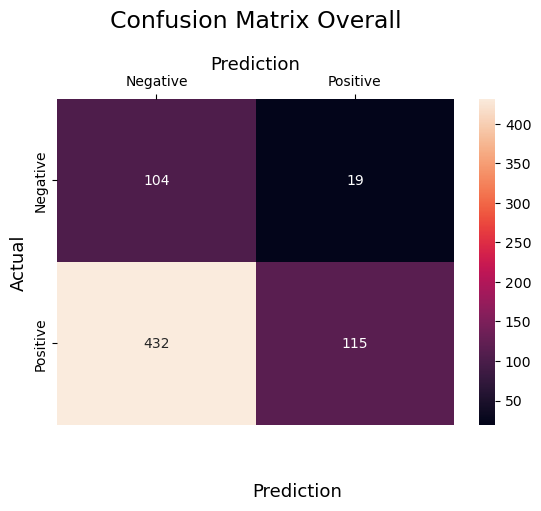

In [53]:
cm = sklearn.metrics.confusion_matrix(joined_df['Actual_Outcome'],joined_df['Predicted_Outcome'])
sns.heatmap(cm, 

            annot=True,

            fmt='g', 

            xticklabels=['Negative','Positive'],

            yticklabels=['Negative','Positive'])

plt.ylabel('Actual', fontsize=13)

plt.title('Confusion Matrix Overall', fontsize=17, pad=20)

plt.gca().xaxis.set_label_position('top') 

plt.xlabel('Prediction', fontsize=13)

plt.gca().xaxis.tick_top()
 
plt.gca().figure.subplots_adjust(bottom=0.2)

plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)

plt.show()

 

In [54]:
joined_df['Predicted_Outcome'] = joined_df.apply(lambda row: "Positive" if row['Derived_progression_quintile'] in [3,4,5] else "Negative", axis=1)
joined_df = joined_df[['StudentNumber', 'IPLEVEL','Concatenated_column', 'Actual_Outcome','Predicted_Outcome','Predicted_outcome_rate', 'Derived_progression_quintile']]

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 56, Finished, Available, Finished)

<mark>**Classification report showing accuracy,precision,recall,f1 score**</mark>

In [55]:
classification_report_pt = sklearn.metrics.classification_report(joined_df['Actual_Outcome'],joined_df['Predicted_Outcome'],  digits=2, output_dict=False, zero_division=0)
print(classification_report_pt)

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 57, Finished, Available, Finished)

              precision    recall  f1-score   support

    Negative       0.21      0.70      0.33       123
    Positive       0.86      0.42      0.56       547

    accuracy                           0.47       670
   macro avg       0.54      0.56      0.44       670
weighted avg       0.74      0.47      0.52       670



<mark>**confusion matrix where we get count of truly classified flags and wrongly classified flags. we try to increase the count of true classifications and reduce false classifications as much as possible by these threshold iterations.**</mark>

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 58, Finished, Available, Finished)

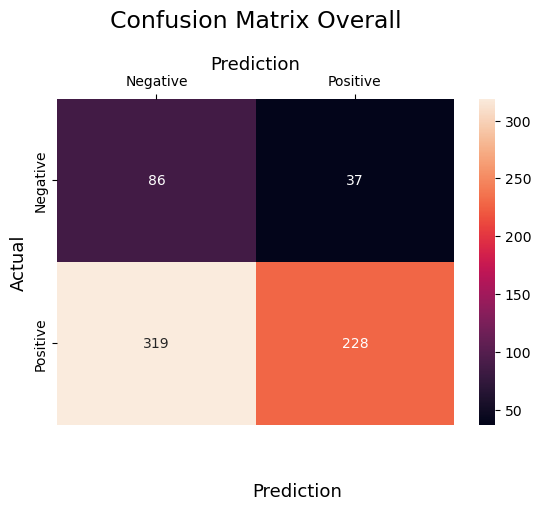

In [56]:
cm = sklearn.metrics.confusion_matrix(joined_df['Actual_Outcome'],joined_df['Predicted_Outcome'])
sns.heatmap(cm, 

            annot=True,

            fmt='g', 

            xticklabels=['Negative','Positive'],

            yticklabels=['Negative','Positive'])

plt.ylabel('Actual', fontsize=13)

plt.title('Confusion Matrix Overall', fontsize=17, pad=20)

plt.gca().xaxis.set_label_position('top') 

plt.xlabel('Prediction', fontsize=13)

plt.gca().xaxis.tick_top()
 
plt.gca().figure.subplots_adjust(bottom=0.2)

plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)

plt.show()

 

In [95]:
joined_df['Predicted_Outcome'] = joined_df.apply(lambda row: "Positive" if row['Predicted_outcome_rate'] >0.5 else "Negative", axis=1)
joined_df = joined_df[['StudentNumber', 'IPLEVEL','Concatenated_column', 'Actual_Outcome','Predicted_Outcome','Predicted_outcome_rate', 'Derived_progression_quintile']]

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 97, Finished, Available, Finished)

In [96]:
classification_report_pt = sklearn.metrics.classification_report(joined_df['Actual_Outcome'],joined_df['Predicted_Outcome'],  digits=2, output_dict=False, zero_division=0)
print(classification_report_pt)

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 98, Finished, Available, Finished)

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       123
    Positive       0.82      1.00      0.90       547

    accuracy                           0.81       670
   macro avg       0.41      0.50      0.45       670
weighted avg       0.67      0.81      0.73       670



**<mark>creating predicted outcome column positive progression rate threshold = 0.7</mark>**

In [57]:
joined_df['Predicted_Outcome'] = joined_df.apply(lambda row: "Positive" if row['Predicted_outcome_rate'] >0.7 else "Negative", axis=1)
joined_df = joined_df[['StudentNumber', 'IPLEVEL','Concatenated_column', 'Actual_Outcome','Predicted_Outcome','Predicted_outcome_rate', 'Derived_progression_quintile']]

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 59, Finished, Available, Finished)

In [58]:
joined_df

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 60, Finished, Available, Finished)

,StudentNumber,IPLEVEL,Concatenated_column,Actual_Outcome,Predicted_Outcome,Predicted_outcome_rate,Derived_progression_quintile
0,STU59079,PGTM,"Quintile 321-25Sensory, medical or physical im...",Positive,Positive,0.730000,1
1,STU59158,PGTM,"Quintile 221-25Sensory, medical or physical im...",Negative,Positive,0.750000,1
2,STU69756,PGTM,Quintile 321-25Social or communication impairm...,Positive,Negative,0.660000,1
3,STU56579,DEG,Quintile 121-25Mental health conditionWhiteQui...,Negative,Negative,0.600000,1
4,STU74215,DEG,Quintile 221-25Mental health conditionAsian or...,Negative,Negative,0.530000,1
...,...,...,...,...,...,...,...
665,STU54158,DEG,Quintile 231-40No disability reportedOther eth...,Positive,Positive,0.820000,3
666,STU42083,DEG,Quintile 531-40No disability reportedAsian or ...,Positive,Positive,0.900000,5
667,STU49976,PGTM,Quintile 531-40No disability reportedAsian or ...,Positive,Positive,0.890000,5
668,STU40896,PGTM,Quintile 531-40No disability reportedAsian or ...,Positive,Positive,0.860000,5


In [59]:
# final_output_df = pd.merge(concat_hist_char_export.drop('Outcome', axis=1), joined_df[['StudentNumber', 'IPLEVEL','Actual_Outcome', 'Predicted_Outcome', 'Predicted_outcome_rate', 'Derived_progression_quintile']], on=['StudentNumber', 'IPLEVEL'], how='inner')
# final_output_df

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 61, Finished, Available, Finished)

In [60]:
# filtered_df = final_output_df.drop(['ethnicity_16_groups', 'sex', 'disability_type'], axis=1)
# filtered_df

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 62, Finished, Available, Finished)

In [61]:
# filtered_df.sort_values(by='Predicted_outcome_rate', ascending=True)

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 63, Finished, Available, Finished)

<mark>**Classification report showing accuracy,precision,recall,f1 score**</mark>

In [62]:
classification_report_pt = sklearn.metrics.classification_report(joined_df['Actual_Outcome'],joined_df['Predicted_Outcome'],  digits=2, output_dict=False, zero_division=0)
print(classification_report_pt)

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 64, Finished, Available, Finished)

              precision    recall  f1-score   support

    Negative       0.36      0.20      0.25       123
    Positive       0.84      0.92      0.88       547

    accuracy                           0.79       670
   macro avg       0.60      0.56      0.56       670
weighted avg       0.75      0.79      0.76       670



<mark>**confusion matrix where we get count of truly classified flags and wrongly classified flags. we try to increase the count of true classifications and reduce false classifications as much as possible by these threshold iterations.**</mark>

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 65, Finished, Available, Finished)

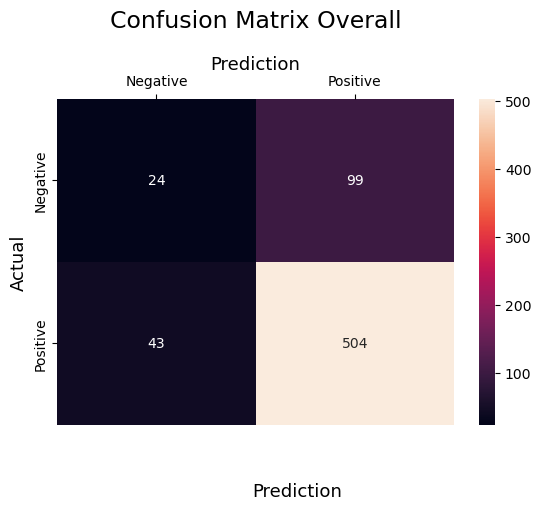

In [63]:
cm = sklearn.metrics.confusion_matrix(joined_df['Actual_Outcome'],joined_df['Predicted_Outcome'])
sns.heatmap(cm, 

            annot=True,

            fmt='g', 

            xticklabels=['Negative','Positive'],

            yticklabels=['Negative','Positive'])

plt.ylabel('Actual', fontsize=13)

plt.title('Confusion Matrix Overall', fontsize=17, pad=20)

plt.gca().xaxis.set_label_position('top') 

plt.xlabel('Prediction', fontsize=13)

plt.gca().xaxis.tick_top()
 
plt.gca().figure.subplots_adjust(bottom=0.2)

plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)

plt.show()

 

<mark>**Divide above df into 5 df based of iplevel**</mark>

In [64]:
joined_df['IPLEVEL'].value_counts()

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 66, Finished, Available, Finished)

IPLEVEL
DEG     341
PGTM    259
OUG      54
OPGT     15
PUGO      1
Name: count, dtype: int64

In [65]:
joined_df_DEG = joined_df[joined_df['IPLEVEL']=='DEG']

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 67, Finished, Available, Finished)

In [66]:
joined_df_DEG.nunique()

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 68, Finished, Available, Finished)

StudentNumber                   341
IPLEVEL                           1
Concatenated_column             302
Actual_Outcome                    2
Predicted_Outcome                 2
Predicted_outcome_rate           34
Derived_progression_quintile      5
dtype: int64

In [67]:
joined_df_DEG['Actual_Outcome'].value_counts()

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 69, Finished, Available, Finished)

Actual_Outcome
Positive    275
Negative     66
Name: count, dtype: int64

In [68]:
joined_df_DEG['Predicted_Outcome'].value_counts()

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 70, Finished, Available, Finished)

Predicted_Outcome
Positive    306
Negative     35
Name: count, dtype: int64

In [69]:
joined_df_PGTM = joined_df[joined_df['IPLEVEL']=='PGTM']

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 71, Finished, Available, Finished)

In [70]:
joined_df_PGTM.nunique()

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 72, Finished, Available, Finished)

StudentNumber                   259
IPLEVEL                           1
Concatenated_column             231
Actual_Outcome                    2
Predicted_Outcome                 2
Predicted_outcome_rate           34
Derived_progression_quintile      5
dtype: int64

In [71]:
joined_df_PGTM['Actual_Outcome'].value_counts()

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 73, Finished, Available, Finished)

Actual_Outcome
Positive    213
Negative     46
Name: count, dtype: int64

In [72]:
joined_df_PGTM['Predicted_Outcome'].value_counts()

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 74, Finished, Available, Finished)

Predicted_Outcome
Positive    233
Negative     26
Name: count, dtype: int64

In [73]:
joined_df_OPGT = joined_df[joined_df['IPLEVEL']=='OPGT']

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 75, Finished, Available, Finished)

In [74]:
joined_df_OPGT.nunique()

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 76, Finished, Available, Finished)

StudentNumber                   15
IPLEVEL                          1
Concatenated_column             15
Actual_Outcome                   1
Predicted_Outcome                2
Predicted_outcome_rate          13
Derived_progression_quintile     5
dtype: int64

In [75]:
joined_df_OPGT['Actual_Outcome'].value_counts()

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 77, Finished, Available, Finished)

Actual_Outcome
Positive    15
Name: count, dtype: int64

In [76]:
joined_df_OPGT['Predicted_Outcome'].value_counts()

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 78, Finished, Available, Finished)

Predicted_Outcome
Positive    11
Negative     4
Name: count, dtype: int64

In [77]:
joined_df_OUG = joined_df[joined_df['IPLEVEL']=='OUG']

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 79, Finished, Available, Finished)

In [78]:
joined_df_OUG.nunique()

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 80, Finished, Available, Finished)

StudentNumber                   54
IPLEVEL                          1
Concatenated_column             51
Actual_Outcome                   2
Predicted_Outcome                2
Predicted_outcome_rate          19
Derived_progression_quintile     5
dtype: int64

In [79]:
joined_df_OUG['Actual_Outcome'].value_counts()

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 81, Finished, Available, Finished)

Actual_Outcome
Positive    43
Negative    11
Name: count, dtype: int64

In [80]:
joined_df_OUG['Predicted_Outcome'].value_counts()

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 82, Finished, Available, Finished)

Predicted_Outcome
Positive    52
Negative     2
Name: count, dtype: int64

In [81]:
joined_df_PUGO = joined_df[joined_df['IPLEVEL']=='PUGO']

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 83, Finished, Available, Finished)

In [82]:
joined_df_PUGO['Actual_Outcome'].value_counts()

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 84, Finished, Available, Finished)

Actual_Outcome
Positive    1
Name: count, dtype: int64

In [83]:
joined_df_PUGO['Predicted_Outcome'].value_counts()

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 85, Finished, Available, Finished)

Predicted_Outcome
Positive    1
Name: count, dtype: int64

<mark>**Performance**</mark>

In [84]:
classes = ['Positive','Negative']

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 86, Finished, Available, Finished)

<mark>**Classification report showing accuracy,precision,recall,f1 score**</mark>

In [85]:
classification_report_DEG = sklearn.metrics.classification_report(joined_df_DEG['Actual_Outcome'],joined_df_DEG['Predicted_Outcome'],  digits=2, output_dict=False, zero_division='warn')
print(classification_report_DEG)

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 87, Finished, Available, Finished)

              precision    recall  f1-score   support

    Negative       0.51      0.27      0.36        66
    Positive       0.84      0.94      0.89       275

    accuracy                           0.81       341
   macro avg       0.68      0.61      0.62       341
weighted avg       0.78      0.81      0.79       341



In [86]:
classification_report_PGTM = sklearn.metrics.classification_report(joined_df_PGTM['Actual_Outcome'],joined_df_PGTM['Predicted_Outcome'],  digits=2, output_dict=False, zero_division='warn')
print(classification_report_PGTM)

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 88, Finished, Available, Finished)

              precision    recall  f1-score   support

    Negative       0.19      0.11      0.14        46
    Positive       0.82      0.90      0.86       213

    accuracy                           0.76       259
   macro avg       0.51      0.51      0.50       259
weighted avg       0.71      0.76      0.73       259



In [87]:
classification_report_OUG = sklearn.metrics.classification_report(joined_df_OUG['Actual_Outcome'],joined_df_OUG['Predicted_Outcome'],  digits=2, output_dict=False, zero_division='warn')
print(classification_report_OUG)

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 89, Finished, Available, Finished)

              precision    recall  f1-score   support

    Negative       0.50      0.09      0.15        11
    Positive       0.81      0.98      0.88        43

    accuracy                           0.80        54
   macro avg       0.65      0.53      0.52        54
weighted avg       0.75      0.80      0.74        54



In [88]:
classification_report_PUGO= sklearn.metrics.classification_report(joined_df_PUGO['Actual_Outcome'],joined_df_PUGO['Predicted_Outcome'],  digits=2, output_dict=False, zero_division='warn')
print(classification_report_PUGO)

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 90, Finished, Available, Finished)

              precision    recall  f1-score   support

    Positive       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1



In [89]:
classification_report_OPGT = sklearn.metrics.classification_report(joined_df_OPGT['Actual_Outcome'],joined_df_OPGT['Predicted_Outcome'],  digits=2, output_dict=False, zero_division=0)
print(classification_report_OPGT)

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 91, Finished, Available, Finished)

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00         0
    Positive       1.00      0.73      0.85        15

    accuracy                           0.73        15
   macro avg       0.50      0.37      0.42        15
weighted avg       1.00      0.73      0.85        15



<mark>**confusion matrix where we get count of truly classified flags and wrongly classified flags. we try to increase the count of true classifications and reduce false classifications as much as possible by these threshold iterations.**</mark>

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 92, Finished, Available, Finished)

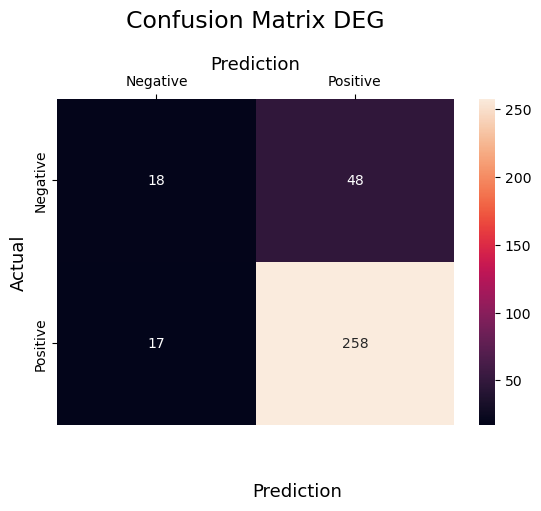

In [90]:
cm = sklearn.metrics.confusion_matrix(joined_df_DEG['Actual_Outcome'],joined_df_DEG['Predicted_Outcome'])
sns.heatmap(cm, 

            annot=True,

            fmt='g', 

            xticklabels=['Negative','Positive'],

            yticklabels=['Negative','Positive'])

plt.ylabel('Actual', fontsize=13)

plt.title('Confusion Matrix DEG', fontsize=17, pad=20)

plt.gca().xaxis.set_label_position('top') 

plt.xlabel('Prediction', fontsize=13)

plt.gca().xaxis.tick_top()
 
plt.gca().figure.subplots_adjust(bottom=0.2)

plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)

plt.show()

 

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 93, Finished, Available, Finished)

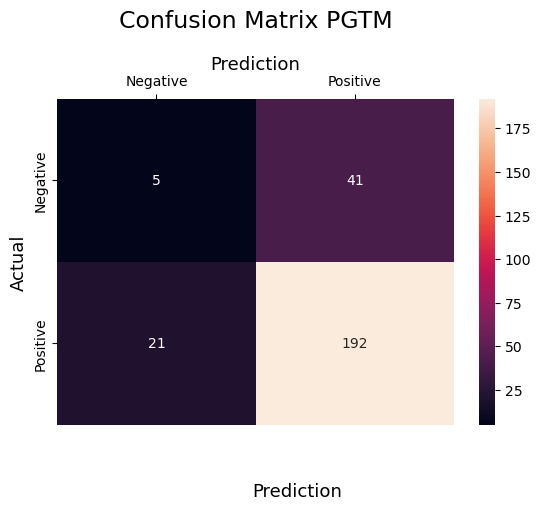

In [91]:
cm = sklearn.metrics.confusion_matrix(joined_df_PGTM['Actual_Outcome'],joined_df_PGTM['Predicted_Outcome'])
sns.heatmap(cm, 

            annot=True,

            fmt='g', 

            xticklabels=['Negative','Positive'],

            yticklabels=['Negative','Positive'])

plt.ylabel('Actual', fontsize=13)

plt.title('Confusion Matrix PGTM', fontsize=17, pad=20)

plt.gca().xaxis.set_label_position('top') 

plt.xlabel('Prediction', fontsize=13)

plt.gca().xaxis.tick_top()
 
plt.gca().figure.subplots_adjust(bottom=0.2)

plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)

plt.show()

 

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 94, Finished, Available, Finished)

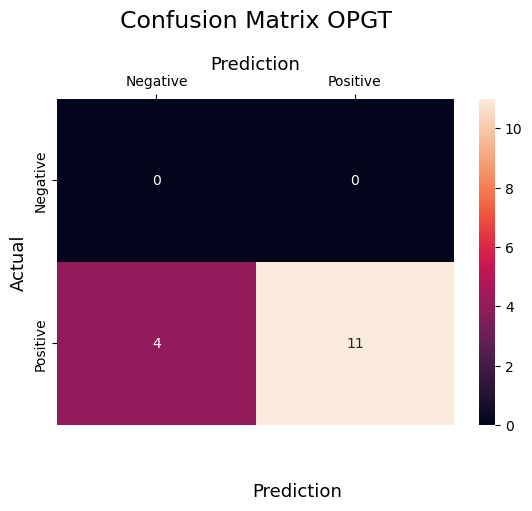

In [92]:
cm = sklearn.metrics.confusion_matrix(joined_df_OPGT['Actual_Outcome'],joined_df_OPGT['Predicted_Outcome'])
sns.heatmap(cm, 

            annot=True,

            fmt='g', 

            xticklabels=['Negative','Positive'],

            yticklabels=['Negative','Positive'])

plt.ylabel('Actual', fontsize=13)

plt.title('Confusion Matrix OPGT', fontsize=17, pad=20)

plt.gca().xaxis.set_label_position('top') 

plt.xlabel('Prediction', fontsize=13)

plt.gca().xaxis.tick_top()
 
plt.gca().figure.subplots_adjust(bottom=0.2)

plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)

plt.show()

 

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 95, Finished, Available, Finished)

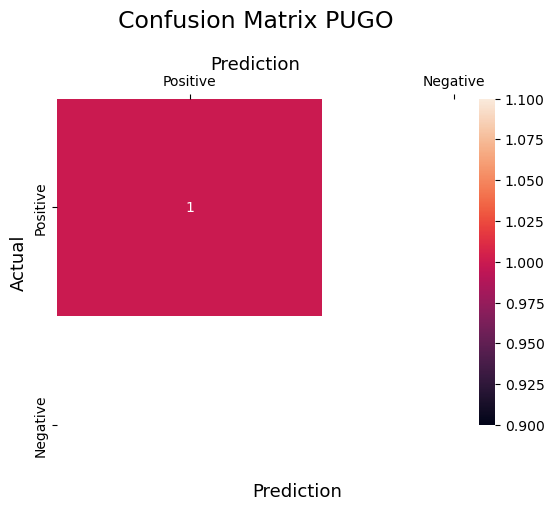

In [93]:
cm = sklearn.metrics.confusion_matrix(joined_df_PUGO['Actual_Outcome'],joined_df_PUGO['Predicted_Outcome'])
sns.heatmap(cm, 

            annot=True,

            fmt='g', 

            xticklabels=['Positive','Negative'],

            yticklabels=['Positive','Negative'])

plt.ylabel('Actual', fontsize=13)

plt.title('Confusion Matrix PUGO', fontsize=17, pad=20)

plt.gca().xaxis.set_label_position('top') 

plt.xlabel('Prediction', fontsize=13)

plt.gca().xaxis.tick_top()
 
plt.gca().figure.subplots_adjust(bottom=0.2)

plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)

plt.show()

StatementMeta(, 03b43061-bddb-44af-bd0f-c4e697463c4a, 96, Finished, Available, Finished)

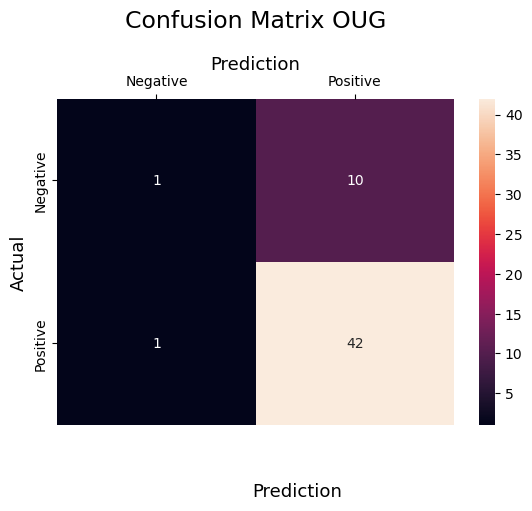

In [94]:
cm = sklearn.metrics.confusion_matrix(joined_df_OUG['Actual_Outcome'],joined_df_OUG['Predicted_Outcome'])
sns.heatmap(cm, 

            annot=True,

            fmt='g', 

            xticklabels=['Negative','Positive'],

            yticklabels=['Negative','Positive'])

plt.ylabel('Actual', fontsize=13)

plt.title('Confusion Matrix OUG', fontsize=17, pad=20)

plt.gca().xaxis.set_label_position('top') 

plt.xlabel('Prediction', fontsize=13)

plt.gca().xaxis.tick_top()
 
plt.gca().figure.subplots_adjust(bottom=0.2)

plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)

plt.show()